In [1]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
from networkx.algorithms.simple_paths import all_simple_paths
import pygraphviz as pgv
from IPython.display import Image
from matplotlib import pyplot as plt
from matplotlib import colors
from random import shuffle
from itertools import cycle, chain
from collections import defaultdict
import json
import yaml

%matplotlib inline

In [2]:
def plt_draw(graph, colors=None, figsize=(30,30)):
    if colors is None:
        colors = ["white" for n in graph.nodes]
    plt.figure(figsize=figsize)
    pos = graphviz_layout(graph, prog="dot")
    nx.draw(graph, with_labels=True, node_color=colors)

In [3]:
css_colors = list(colors.CSS4_COLORS.keys())
shuffle(css_colors)
colors = list(colors.BASE_COLORS.keys()) + css_colors
colors = cycle(colors)

In [4]:
def do_wave(n, color):
    print("Starting wave", n)
    waves[n] = list()
    for package in waves[n-1]:
        print(f"# {package}")
        what_requires = !repoquery --repo=rawhide --qf '%{{NAME}}' --whatrequires {package} 2> /dev/null
        for dependant in what_requires:
            if dependant in binary_exc:
                print("X", dependant, "has an exception")
                continue
            if dependant not in g.nodes:
                print("A", dependant, "→", package)
                waves[n].append(dependant)
                g.add_edge(dependant, package)
                node_colors.append(color)
    print(len(waves[n]), "new packages")
    return len(waves[n])

## Maintainers

In [5]:
with open("../portingdb/data/pagure_owner_alias.json") as fh:
    maintainers = json.load(fh)["rpms"]

inverse_maintainers = defaultdict(list)
for srpm in maintainers:
    for maintainer in maintainers[srpm]:
        inverse_maintainers[maintainer].append(srpm)

## Orphaned packages

In [6]:
srpm_orphans = []
for srpm, srpm_maintainers in maintainers.items():
    if "orphan" in srpm_maintainers:
        srpm_orphans.append(srpm)

## Exceptions

Get groups from portingdb

In [7]:
with open("../portingdb/data/groups.yaml") as fh:
    groups = yaml.load(fh, Loader=yaml.SafeLoader)

Get all non-hidden source RPM packages (have an exception)

In [8]:
source_exc = []
for srpm, info in groups.items():
    if info.get("hidden", False):
        continue
    for package in info["packages"]:
        source_exc.append(package)

In [9]:
source_exc.extend(["mercurial", "autodownloader"])  # manually added exceptions

Get mapping from portingdb to get binary RPMs from source RPMs

In [10]:
with open("../portingdb/_check_drops/results-sources.json") as fh:
    srpm_mapping = json.load(fh)

In [11]:
binary_exc = []
for package in source_exc:
    binary_exc.extend(srpm_mapping[package])

In [12]:
binary_exc.append("python2-capstone")  # Bogus dependencies https://bugzilla.redhat.com/show_bug.cgi?id=1760277#c1
binary_exc.append("python3-dmidecode")  # same as above

In [13]:
print(f"SRPM exceptions - {source_exc}\nRPM exceptions {binary_exc}")

SRPM exceptions - ['gimp', 'gimp-layer-via-copy-cut', 'gimp-resynthesizer', 'pygobject2', 'pygtk2', 'pycairo', 'chromium', 'python-psutil', 'mlt', 'postgresql', 'pypy', 'pypy3', 'qt5-qtwebengine', 'texlive-base', 'autodownloader', 'mozjs60', 'mercurial', 'mercurial', 'autodownloader']
RPM exceptions ['gimp-devel-tools', 'gimp-libs', 'gimp', 'gimp-devel', 'gimp-layer-via-copy-cut', 'gimp-resynthesizer', 'pygobject2-codegen', 'pygobject2', 'pygobject2-devel', 'pygobject2-doc', 'pygtk2-doc', 'pygtk2-devel', 'pygtk2-codegen', 'pygtk2', 'pygtk2-libglade', 'python3-cairo', 'python3-cairo-devel', 'python2-cairo-devel', 'python2-cairo', 'chromedriver', 'chromium-libs-media', 'chromium-libs', 'chromium-headless', 'chromium-common', 'chromium', 'chrome-remote-desktop', 'python3-psutil', 'python2-psutil', 'mlt-php', 'mlt', 'python2-mlt', 'mlt-ruby', 'mlt-devel', 'postgresql-test', 'postgresql-upgrade', 'postgresql-plpython3', 'postgresql-server-devel', 'postgresql-server', 'postgresql-static', 'p

## Wave #1 - packages directly depending on python27

In [14]:
waves = {}

In [15]:
python27 = !repoquery --repo=rawhide --qf "%{NAME}" --whatrequires python27 2> /dev/null

In [16]:
waves[1] = set([p for p in python27 if p not in binary_exc])

In [17]:
g = nx.DiGraph()
node_colors = []

In [18]:
g.add_nodes_from(waves[1])

In [19]:
for package in waves[1]:
    g.add_edge(package, "PY2")
    # g.add_node(package)
    node_colors.append("red")
node_colors.append("red")

In [20]:
len(waves[1])

351

## Wave 2, 3, 4, …

In [21]:
for n in range(2, 20):
    color = next(colors)
    new_pkgs = do_wave(n, color)
    if new_pkgs == 0:
        break

Starting wave 2
# python2-ioprocess
# shedskin
# trac-privateticketsplugin
# python2-idna
# angrydd
# votca-csg-common
A votca-csg → votca-csg-common
A votca-csg-doc → votca-csg-common
A votca-xtp-doc → votca-csg-common
# uhd
A uhd-devel → uhd
A uhd-firmware → uhd
A uhd-tools → uhd
A urh → uhd
# sugar
A sugar-cp-all → sugar
A sugar-cp-background → sugar
A sugar-cp-backup → sugar
A sugar-cp-datetime → sugar
A sugar-cp-frame → sugar
A sugar-cp-keyboard → sugar
A sugar-cp-language → sugar
A sugar-cp-modemconfiguration → sugar
A sugar-cp-network → sugar
A sugar-cp-power → sugar
A sugar-cp-updater → sugar
A sugar-cp-webaccount → sugar
A sugar-flip → sugar
# gnome-python2-canvas
A gnome-python2-desktop → gnome-python2-canvas
# sugar-datastore
# gnome-python2-gnome
A audit-viewer → gnome-python2-gnome
# macromilter
A glpi → macromilter
A iipsrv → macromilter
A php-horde-horde → macromilter
# python2-iniparse
# hg-git
# python2-socksipychain
# trac-mercurial-plugin
# python2-zope-event
# sugar

A tortoisehg-nautilus → tortoisehg
# gr-hpsdr
A gr-hpsdr-devel → gr-hpsdr
A gr-hpsdr-doc → gr-hpsdr
# python2-attrs
# sugar-connect
# python2-setuptools
# sugar-xoeditor
# rtlsdr-scanner
A rtlsdr-scanner-doc → rtlsdr-scanner
# pynag
# python2-musicbrainzngs
# python2-dbus
A lokalize → python2-dbus
# oggify
# trac-accountmanager-plugin
# gdesklets
# trac-monotone-plugin
# pyifp
# captcp
# python2-mod_wsgi
A viewmtn → python2-mod_wsgi
# gnuradio
A gnuradio-devel → gnuradio
A gnuradio-doc → gnuradio
A gqrx → gnuradio
A gr-iio → gnuradio
# ddiskit
# sugar-portfolio
# python2-notify
# sugar-xoirc
# gnome-python2-gconf
# gnome-python2-devel
# python2-telepathy
# python2-futures
# python2-py
# python2-coverage
# python2-prettytable
# boost-python2
# python2-pillow
# seafile
A seafile-client → seafile
A seafile-devel → seafile
# nfspy
# python2-numpy
A python2-numpy-doc → python2-numpy
# gnome-python2-gnomekeyring
# python2-skf
# python2-cheetah
# python2-blist
# python2-backports
# python2-mi

## Save

In [22]:
nx.write_adjlist(g, "full_graph.adjlist")

In [23]:
waves[1] = list(waves[1])

In [24]:
with open("wawes.json", "w") as fh:
    json.dump(waves, fh)
with open("node_colors.json", "w") as fh:
    json.dump(node_colors, fh)

## Load

In [25]:
with open("wawes.json") as fh:
    waves = json.load(fh)
with open("node_colors.json") as fh:
    node_colors = json.load(fh)

In [26]:
g = nx.read_adjlist("full_graph.adjlist", create_using=nx.DiGraph())

In [27]:
"PY2" in g.nodes

True

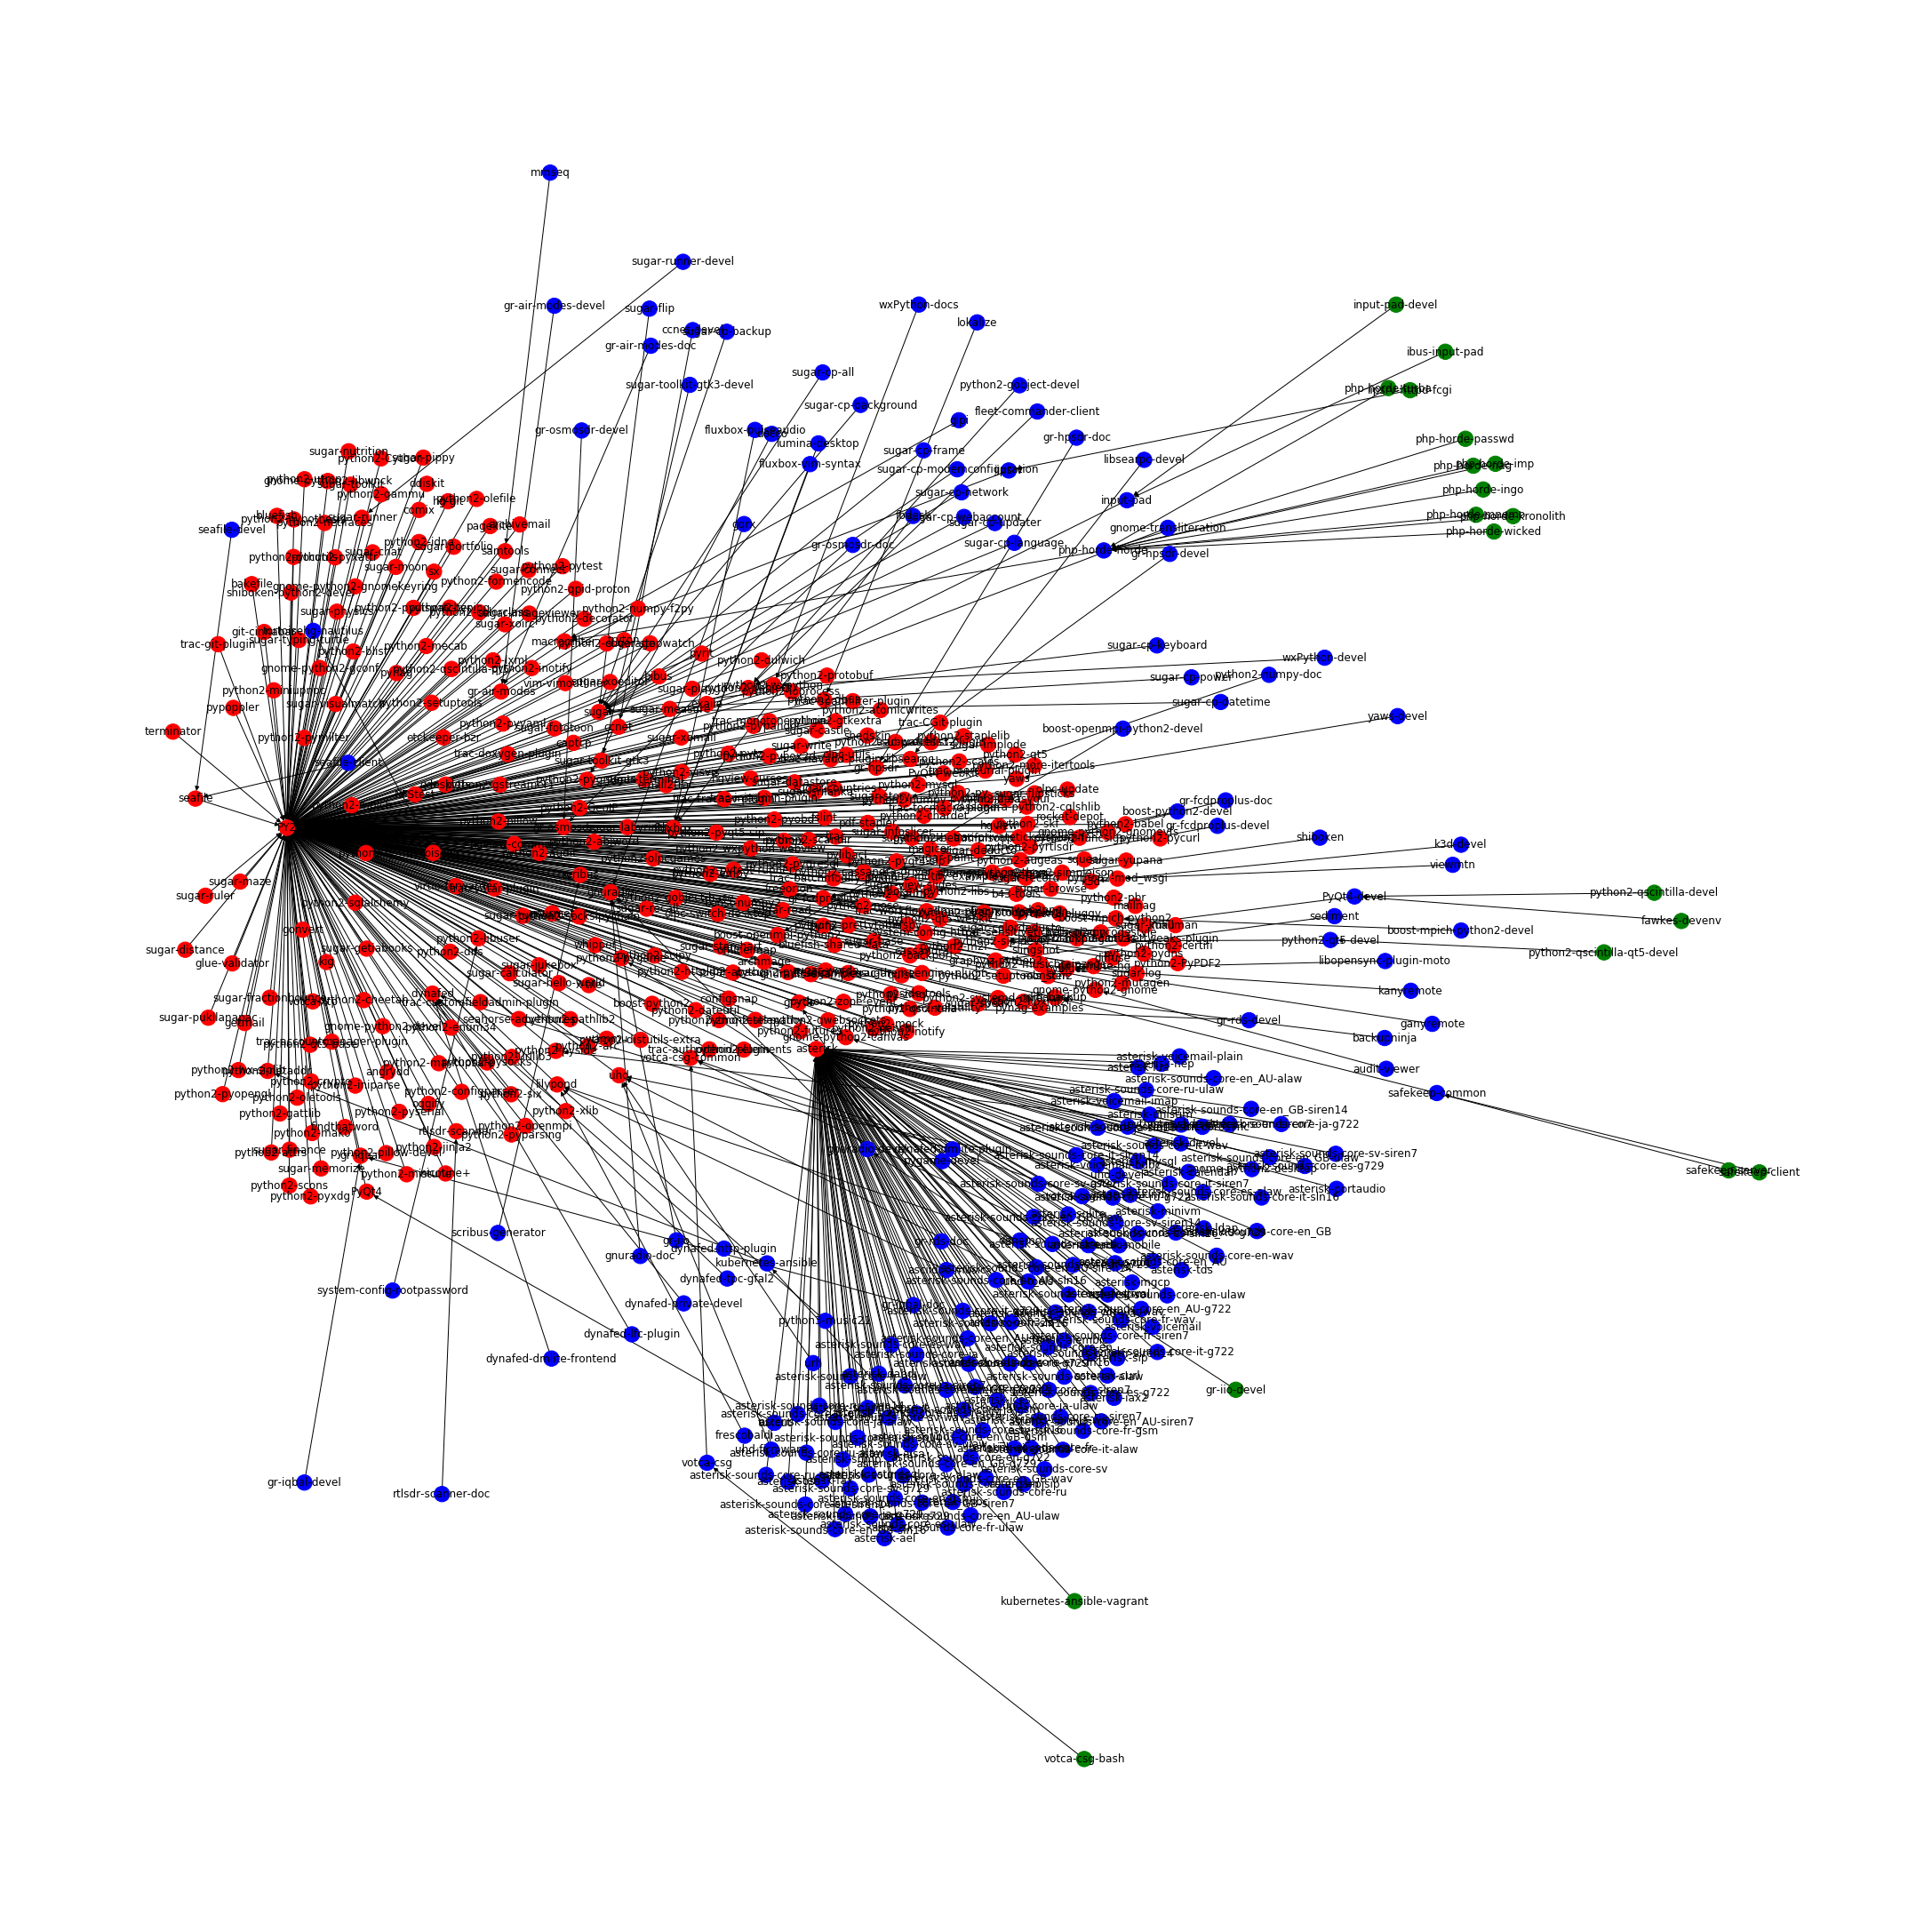

In [28]:
plt_draw(g, node_colors)

## List of packages and theirs paths to Python 2 (including the packages in the first wave)

In [29]:
len(waves)

4

In [30]:
with open("packages.txt", "w") as packages_file:
    binary_packages = list(chain(*[waves[str(n)] for n in waves.keys()]))
    print("Total packages", len(binary_packages))
    for package in sorted(binary_packages):
        path = list(all_simple_paths(g, package, 'PY2'))[0]
        line = f"{package} ({' → '.join(path)})"
        print(line)
        print(line, file=packages_file)

!scp packages.txt fedorapeople.org:public_html/ >/dev/null

Total packages 591
NFStest (NFStest → PY2)
PyQt4 (PyQt4 → PY2)
PyQt4-devel (PyQt4-devel → python2-sip-devel → PY2)
PyQt4-webkit (PyQt4-webkit → PY2)
angrydd (angrydd → PY2)
archivemail (archivemail → PY2)
archmage (archmage → PY2)
asciidoc-music (asciidoc-music → lilypond → PY2)
asterisk (asterisk → PY2)
asterisk-ael (asterisk-ael → asterisk → PY2)
asterisk-alembic (asterisk-alembic → asterisk → PY2)
asterisk-alsa (asterisk-alsa → asterisk → PY2)
asterisk-calendar (asterisk-calendar → asterisk → PY2)
asterisk-corosync (asterisk-corosync → asterisk → PY2)
asterisk-curl (asterisk-curl → asterisk → PY2)
asterisk-dahdi (asterisk-dahdi → asterisk → PY2)
asterisk-devel (asterisk-devel → asterisk → PY2)
asterisk-fax (asterisk-fax → asterisk → PY2)
asterisk-festival (asterisk-festival → asterisk → PY2)
asterisk-hep (asterisk-hep → asterisk → PY2)
asterisk-iax2 (asterisk-iax2 → asterisk → PY2)
asterisk-ices (asterisk-ices → asterisk → PY2)
asterisk-ldap (asterisk-ldap → asterisk → PY2)
asterisk

## List of all SRPMs and theirs RPMs

In [31]:
inverse_srpm_map = {}
for srpm, pkgs in srpm_mapping.items():
    inverse_srpm_map.update({pkg: srpm for pkg in pkgs})

In [32]:
srpms = defaultdict(list)
for package in binary_packages:
    try:
        srpm = inverse_srpm_map[package]
    except KeyError:
        srpm = "N/A"
    srpms[srpm].append(package)

## List of affected maintainers and their binary RPMs

In [33]:
affected_maintainers = defaultdict(list)
for package in binary_packages:
    try:
        srpm = inverse_srpm_map[package]
    except KeyError:
        srpm = "N/A"
    for maintainer in maintainers.get(srpm, []):
        affected_maintainers[maintainer].append(package)

with open("affected_maintainers.txt", "w") as affected_maintainer_file:
    for maintainer, pkgs in sorted(affected_maintainers.items(), key=lambda x: x[0]):
        line = f"{maintainer} - {', '.join(pkgs)}"
        print(line)
        print(line, file=affected_maintainer_file)

!scp affected_maintainers.txt fedorapeople.org:public_html/ >/dev/null

aarem - python2-PyPDF2, pdf-stapler, python2-more-itertools, python2-staplelib
abbot - python2-protobuf
abompard - python2-zope-event, python2-httplib2, python2-pysocks, python2-urllib3, python2-coverage, python2-mako
acaringi - cassandra-python2-cqlshlib, cassandra
ajmitchell - NFStest
alexl - gnome-python2-canvas, gnome-python2-gnome, gnome-python2-gnomevfs, gnome-python2-libwnck, gnome-python2-rsvg, python2-dbus, gnome-python2-gconf, gnome-python2-devel, gnome-python2-gnomekeyring, gnome-python2-desktop
alexlan - graphviz-python2
amluto - python2-musicbrainzngs
andreamanzi - dynafed, dynafed-dmlite-frontend, dynafed-dmlite-plugin, dynafed-http-plugin, dynafed-lfc-plugin, dynafed-private-devel, dynafed-tpc-gfal2
anishpatil - gnome-transliteration
anyremote - ganyremote, kanyremote
aperezbios - sugar, sugar-cp-all, sugar-cp-background, sugar-cp-backup, sugar-cp-datetime, sugar-cp-frame, sugar-cp-keyboard, sugar-cp-language, sugar-cp-modemconfiguration, sugar-cp-network, sugar-cp-power

ivazquez - python2-sqlalchemy
jamatos - python2-pyparsing, python2-configparser
jamielinux - docco
jchaloup - kubernetes-ansible, kubernetes-ansible-vagrant
jcholast - python2-netaddr
jcline - python2-idna, python2-urllib3, python2-chardet
jdekloe - hg-git
jdornak - python2-mysql, python2-mod_wsgi
jdulaney - lilypond
jeckersb - python2-netaddr, python2-pyyaml
jfilak - python2-inotify-examples, python2-inotify
jgrulich - lokalize
jgu - python2-netifaces
jhladky - python2-openmpi
jhrozek - python2-libuser, python2-netaddr
jjanco - cassandra-python2-cqlshlib, cassandra
jkaluza - python2-mod_wsgi
jmlich - python2-pygresql
jmontleon - python2-certifi
johnp - sugar, gnome-python2-canvas, sugar-datastore, gnome-python2-gnome, gnome-python2-gnomevfs, python2-gobject-base, python2-gobject, gnome-python2-libwnck, gnome-python2-rsvg, python2-dbus, gnome-python2-gconf, gnome-python2-devel, gnome-python2-gnomekeyring, sugar-cp-all, sugar-cp-background, sugar-cp-backup, sugar-cp-datetime, sugar-cp-f

## Combined structure

In [34]:
structure = defaultdict(lambda: defaultdict(list))
for binary_pkg in binary_packages:
    try:
        srpm = inverse_srpm_map[binary_pkg]
        srpm_maintainers = maintainers[srpm]
    except KeyError:
        srpm = "N/A"
        srpm_maintainers = ["N/A"]
    for maintainer in srpm_maintainers:
        structure[maintainer][srpm].append(binary_pkg)

# Build dependencies (direct)

In [35]:
srpm_dependants = []
for package in sorted(binary_packages):
    build_requires = !repoquery --repo=rawhide-source --repo=rawhide --qf "%{{NAME}} %{{ARCH}}" --whatrequires {package} 2>/dev/null | grep " src$" | cut -d " " -f 1
    print(f"{package} in required in build time by {build_requires}")
    for srpm in build_requires:
        if srpm in srpms.keys() or srpm in srpm_dependants:
            print(f"✅ {srpm} is already in the graph")
            continue
        if srpm in source_exc:
            print(f"✅ {srpm} in in the list of source ackages with exceptions")
            continue
        try:
            rpms = srpm_mapping[srpm]
        except KeyError:
            print(f"Cannot get RPMs for {srpm}")
            continue
        if any([p.startswith("python2-") for p in rpms]):
            print(f"✅ {srpm} provides python2 subpackage - {rpms}")
            continue
        
        srpm_dependants.append(srpm)
        g.add_edge(srpm, package)
        srpm_maintainers = maintainers[srpm]
        for maintainer in srpm_maintainers:
            structure[maintainer][srpm].insert(0, "SRPM")  # For these special cases, we'll generate path for SRPM

NFStest in required in build time by []
PyQt4 in required in build time by []
PyQt4-devel in required in build time by ['gnuradio', 'gr-air-modes', 'hgview', 'python-poppler-qt4', 'qscintilla']
✅ gnuradio is already in the graph
✅ gr-air-modes is already in the graph
✅ hgview is already in the graph
✅ qscintilla is already in the graph
PyQt4-webkit in required in build time by []
angrydd in required in build time by []
archivemail in required in build time by []
archmage in required in build time by []
asciidoc-music in required in build time by []
asterisk in required in build time by []
asterisk-ael in required in build time by []
asterisk-alembic in required in build time by []
asterisk-alsa in required in build time by []
asterisk-calendar in required in build time by []
asterisk-corosync in required in build time by []
asterisk-curl in required in build time by []
asterisk-dahdi in required in build time by []
asterisk-devel in required in build time by []
asterisk-fax in required

boost-mpich-python2 in required in build time by []
boost-mpich-python2-devel in required in build time by []
boost-numpy2 in required in build time by []
boost-openmpi-python2 in required in build time by []
boost-openmpi-python2-devel in required in build time by []
boost-python2 in required in build time by []
boost-python2-devel in required in build time by ['freeorion', 'k3d', 'ledger', 'python-gattlib']
✅ freeorion is already in the graph
✅ k3d is already in the graph
✅ python-gattlib is already in the graph
captcp in required in build time by []
cassandra in required in build time by []
cassandra-python2-cqlshlib in required in build time by []
ccnet in required in build time by []
ccnet-devel in required in build time by ['seafile', 'seafile-client']
✅ seafile is already in the graph
✅ seafile-client is already in the graph
comix in required in build time by []
configsnap in required in build time by []
ddiskit in required in build time by []
denemo in required in build time by

python2-arc in required in build time by []
python2-atomicwrites in required in build time by ['python2-pytest']
✅ python2-pytest is already in the graph
python2-attrs in required in build time by ['python-hypothesis', 'python2-pytest']
✅ python-hypothesis is already in the graph
✅ python2-pytest is already in the graph
python2-audit in required in build time by []
python2-augeas in required in build time by []
python2-babel in required in build time by ['python-jinja2', 'trac-accountmanager-plugin', 'trac-spamfilter-plugin']
✅ python-jinja2 is already in the graph
✅ trac-accountmanager-plugin is already in the graph
✅ trac-spamfilter-plugin is already in the graph
python2-backports in required in build time by []
python2-beautifulsoup in required in build time by []
python2-blist in required in build time by []
python2-cassandra-driver in required in build time by []
python2-certifi in required in build time by []
python2-chardet in required in build time by []
python2-cheetah in requ

python2-olefile in required in build time by ['python-oletools', 'python-pillow']
✅ python-oletools is already in the graph
✅ python-pillow is already in the graph
python2-oletools in required in build time by []
python2-olpcgames in required in build time by []
python2-openmpi in required in build time by []
python2-pathlib2 in required in build time by ['python2-pytest']
✅ python2-pytest is already in the graph
python2-pbr in required in build time by ['python-mock']
✅ python-mock is already in the graph
python2-pillow in required in build time by ['comix', 'mcomix', 'trac-spamfilter-plugin']
✅ comix is already in the graph
✅ mcomix is already in the graph
✅ trac-spamfilter-plugin is already in the graph
python2-pillow-devel in required in build time by ['scribus']
✅ scribus is already in the graph
python2-pluggy in required in build time by ['python2-pytest']
✅ python2-pytest is already in the graph
python2-prettytable in required in build time by ['python-oletools']
✅ python-oletoo

python2-setuptools_scm in required in build time by ['python-dateutil', 'python-py', 'python-pytest-runner', 'python-xlib', 'python2-pluggy', 'python2-pytest']
✅ python-dateutil is already in the graph
✅ python-py is already in the graph
✅ python-pytest-runner is already in the graph
✅ python-xlib is already in the graph
✅ python2-pluggy is already in the graph
✅ python2-pytest is already in the graph
python2-simplejson in required in build time by ['libsearpc', 'python-oauth2', 'python-scales']
✅ libsearpc is already in the graph
✅ python-oauth2 is already in the graph
✅ python-scales is already in the graph
python2-sip-devel in required in build time by ['PyQt4', 'avogadro', 'python-qt5', 'qgis', 'qscintilla', 'vtk']
✅ PyQt4 is already in the graph
✅ python-qt5 is already in the graph
✅ qscintilla is already in the graph
python2-six in required in build time by ['gnuradio', 'ioprocess', 'offlineimap', 'python-iniparse', 'python-pathlib2', 'python-scales', 'python-xlib', 'python2-more

sugar-toolkit-gtk3-devel in required in build time by ['sugar-infoslicer', 'sugar-jukebox', 'sugar-paint', 'sugar-read', 'sugar-record', 'sugar-visualmatch', 'sugar-write', 'sugar-xoirc']
✅ sugar-infoslicer is already in the graph
✅ sugar-jukebox is already in the graph
✅ sugar-paint is already in the graph
✅ sugar-read is already in the graph
✅ sugar-record is already in the graph
✅ sugar-visualmatch is already in the graph
✅ sugar-write is already in the graph
✅ sugar-xoirc is already in the graph
sugar-turtleart in required in build time by []
sugar-typing-turtle in required in build time by []
sugar-view-slides in required in build time by []
sugar-visualmatch in required in build time by []
sugar-words in required in build time by []
sugar-write in required in build time by []
sugar-xoeditor in required in build time by []
sugar-xoirc in required in build time by []
sugar-xomail in required in build time by []
sugar-yupana in required in build time by []
sx in required in build ti

### Save

In [36]:
with open("structure.json", "w") as fh:
    json.dump(structure, fh)

### Load

In [37]:
with open("structure.json") as fh:
    structure = json.load(fh)

# Final outputs

## Package structure with paths

In [38]:
with open("report.txt", "w") as report_file:
    for maintainer in sorted(structure.keys()):
        # Skip orphans and unknown maintainers
        if maintainer in ("N/A", "orphan"):
            continue
        lines = []
        lines.append(maintainer)
        for srpm in sorted(structure[maintainer]):
            # Skip orphaned packages
            if srpm in srpm_orphans:
                continue
            lines.append(f"  {srpm}")
            rpms = sorted(structure[maintainer][srpm])
            if srpm in rpms:
                rpms.remove(srpm)
                rpms.insert(0, srpm)
            for rpm in rpms:
                marker = "→ "
                if rpm == "SRPM":
                    rpm = srpm
                    marker = "BuildRequires: "

                # Mark all orphaned packages in the path by (!)
                path = list(all_simple_paths(g, rpm, 'PY2'))[0]
                for index, package in enumerate(path):
                    try:
                        if inverse_srpm_map[package] in srpm_orphans:
                            path[index] = f"{package} (!)"
                    except KeyError:
                        pass

                if path[0] == srpm:
                    del path[0]
                    str_path = marker + ' → '.join(path)
                    line = f"    ({str_path})"
                else:
                    del path[0]
                    str_path = '→ ' + ' → '.join(path)
                    line = f"    {rpm} ({str_path})"
                lines.append(line)

        if any([True for l in lines if l.startswith(" "*4)]):
            print("\n".join(lines))
            print("\n".join(lines), file=report_file)

!scp report.txt fedorapeople.org:public_html/ >/dev/null

aarem
  pdf-stapler
    (→ PY2)
    python2-staplelib (→ PY2)
  python-PyPDF2
    python2-PyPDF2 (→ PY2)
  python2-more-itertools
    (→ PY2)
abbot
  protobuf
    python2-protobuf (→ PY2)
abompard
  python-coverage
    python2-coverage (→ PY2)
  python-httplib2
    python2-httplib2 (→ PY2)
  python-mako
    python2-mako (→ PY2)
  python-pysocks
    python2-pysocks (→ PY2)
  python-urllib3
    python2-urllib3 (→ PY2)
  python-zope-event
    python2-zope-event (→ PY2)
ajmitchell
  NFStest
    (→ PY2)
alexl
  dbus
    (BuildRequires: python2-gobject → PY2)
  dbus-python
    python2-dbus (→ PY2)
  gnome-python2
    gnome-python2-canvas (→ PY2)
    gnome-python2-devel (→ PY2)
    gnome-python2-gconf (→ PY2)
    gnome-python2-gnome (→ PY2)
    gnome-python2-gnomevfs (→ PY2)
  gnome-python2-desktop
    (→ gnome-python2-canvas → PY2)
    gnome-python2-gnomekeyring (→ PY2)
    gnome-python2-libwnck (→ PY2)
    gnome-python2-rsvg (→ PY2)
alexlan
  graphviz
    graphviz-python2 (→ PY2)
alsadi
  d

jsmith
  asterisk
    (→ PY2)
    asterisk-ael (→ asterisk → PY2)
    asterisk-alembic (→ asterisk → PY2)
    asterisk-alsa (→ asterisk → PY2)
    asterisk-calendar (→ asterisk → PY2)
    asterisk-corosync (→ asterisk → PY2)
    asterisk-curl (→ asterisk → PY2)
    asterisk-dahdi (→ asterisk → PY2)
    asterisk-devel (→ asterisk → PY2)
    asterisk-fax (→ asterisk → PY2)
    asterisk-festival (→ asterisk → PY2)
    asterisk-hep (→ asterisk → PY2)
    asterisk-iax2 (→ asterisk → PY2)
    asterisk-ices (→ asterisk → PY2)
    asterisk-ldap (→ asterisk → PY2)
    asterisk-lua (→ asterisk → PY2)
    asterisk-mgcp (→ asterisk → PY2)
    asterisk-minivm (→ asterisk → PY2)
    asterisk-mobile (→ asterisk → PY2)
    asterisk-mwi-external (→ asterisk → PY2)
    asterisk-mysql (→ asterisk → PY2)
    asterisk-odbc (→ asterisk → PY2)
    asterisk-ooh323 (→ asterisk → PY2)
    asterisk-oss (→ asterisk → PY2)
    asterisk-pjsip (→ asterisk → PY2)
    asterisk-portaudio (→ asterisk → PY2)
    asterisk

tuxbrewr
  sugar
    (→ PY2)
    sugar-cp-all (→ sugar → PY2)
    sugar-cp-background (→ sugar → PY2)
    sugar-cp-backup (→ sugar → PY2)
    sugar-cp-datetime (→ sugar → PY2)
    sugar-cp-frame (→ sugar → PY2)
    sugar-cp-keyboard (→ sugar → PY2)
    sugar-cp-language (→ sugar → PY2)
    sugar-cp-modemconfiguration (→ sugar → PY2)
    sugar-cp-network (→ sugar → PY2)
    sugar-cp-power (→ sugar → PY2)
    sugar-cp-updater (→ sugar → PY2)
    sugar-cp-webaccount (→ sugar → PY2)
  sugar-calculator
    (→ PY2)
  sugar-chat
    (→ PY2)
  sugar-clock
    (→ PY2)
  sugar-connect
    (→ PY2)
  sugar-distance
    (→ PY2)
  sugar-finance
    (→ PY2)
  sugar-flipsticks
    (→ PY2)
  sugar-getiabooks
    (→ PY2)
  sugar-imageviewer
    (→ PY2)
  sugar-implode
    (→ PY2)
  sugar-infoslicer
    (→ PY2)
  sugar-log
    (→ PY2)
  sugar-maze
    (→ PY2)
  sugar-memorize
    (→ PY2)
  sugar-pippy
    (→ PY2)
  sugar-playgo
    (→ PY2)
  sugar-read
    (→ PY2)
  sugar-record
    (→ PY2)
  sugar-speak

## Recipients

In [39]:
recipients = set(structure.keys())
for recipient in sorted(recipients):
    if recipient in ("N/A", "orphan") or all([srpm in srpm_orphans for srpm in structure[recipient]]):
        continue
    print(f"{recipient}@fedoraproject.org")

aarem@fedoraproject.org
abbot@fedoraproject.org
abompard@fedoraproject.org
ajmitchell@fedoraproject.org
alexl@fedoraproject.org
alexlan@fedoraproject.org
alsadi@fedoraproject.org
amigadave@fedoraproject.org
amluto@fedoraproject.org
andreamanzi@fedoraproject.org
anishpatil@fedoraproject.org
ankursinha@fedoraproject.org
anyremote@fedoraproject.org
aperezbios@fedoraproject.org
apevec@fedoraproject.org
aruiz@fedoraproject.org
ausil@fedoraproject.org
averi@fedoraproject.org
aviso@fedoraproject.org
awjb@fedoraproject.org
beckerde@fedoraproject.org
besser82@fedoraproject.org
bkabrda@fedoraproject.org
bkearney@fedoraproject.org
bowlofeggs@fedoraproject.org
bpepple@fedoraproject.org
bressers@fedoraproject.org
bronhaim@fedoraproject.org
brouhaha@fedoraproject.org
bruno@fedoraproject.org
bsjones@fedoraproject.org
caillon@fedoraproject.org
callkalpa@fedoraproject.org
caolanm@fedoraproject.org
carlwgeorge@fedoraproject.org
chandankumar@fedoraproject.org
cheese@fedoraproject.org
churchyard@fedorapro

## Save

In [40]:
nx.write_adjlist(g, "full_graph.adjlist")